<a href="https://colab.research.google.com/github/BhargavaSimhaR/AgenticAI/blob/main/RiskStrategyProfiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import os
from getpass import getpass

os.environ["TOGETHER_API_KEY"] = "d0c1567936163f51b02e4eeb91350498a64a9aaac7735b2ef7a8c87e96a88dc3"

In [74]:
from langchain_together.chat_models import ChatTogether
from langgraph.graph import StateGraph, END
from typing import TypedDict
from langchain_core.output_parsers import StrOutputParser
import os
from getpass import getpass

# Shared State
class GraphState(TypedDict):
    user_input: str
    risk_profile: str
    strategy: str
    explanation: str

# Init Together LLM
llm = ChatTogether(
    model="mistralai/Mistral-7B-Instruct-v0.2",
    temperature=0.5,
)

from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import Runnable

# Template for explanation
def generate_explanation(state: GraphState) -> dict:
    explanation_prompt = PromptTemplate.from_template(
    """
    You are a financial advisor bot. A user has the following profile:

    User Input: {user_input}
    Risk Profile: {risk_profile}
    Suggested Investment Plan: {strategy}

    Write a brief explanation (2-4 lines) justifying this investment plan for the user.
    """
    )

    explanation= llm.invoke(explanation_prompt.format(**state)).content
    return {**state, "explanation": explanation}


# Node 1: Risk Profiling
def risk_profile_node(state: GraphState) -> GraphState:
    prompt = f"""Based on the following user details, classify the risk profile as exactly one of: Low, Medium, High.

User details: {state['user_input']}

Just reply with: Low, Medium, or High."""

    response = llm.invoke(prompt).content.strip().lower()

    if "low" in response:
        risk = "Low"
    elif "high" in response:
        risk = "High"
    else:
        risk = "Medium"

    return {**state, "risk_profile": risk}

# Node 2: Route to correct strategy
def route_based_on_risk(state: GraphState) -> str:
    return state["risk_profile"]  # Should be exactly Low / Medium / High

# Node 3: Strategy Nodes
def low_risk_strategy(state: GraphState) -> GraphState:
    return {**state, "strategy": "60% Fixed Deposits, 20% Bonds, 10% Mutual Funds, 10% Gold"}

def medium_risk_strategy(state: GraphState) -> GraphState:
    return {**state, "strategy": "40% Mutual Funds, 30% Stocks, 15% Gold, 15% Real Estate"}

def high_risk_strategy(state: GraphState) -> GraphState:
    return {**state, "strategy": "70% Stocks, 20% Crypto, 10% Mutual Funds"}

# Node 4: Format Output
def format_output(state: GraphState) -> GraphState:
    return {**state, "strategy": f"""
✅ Investment Plan:
- Risk Profile: {state['risk_profile']}
- Suggested Allocation: {state['strategy']}

✅ Explanation:
{state['explanation']}
"""}

# Define LangGraph
builder = StateGraph(GraphState)

builder.set_entry_point("risk_profiling")

# Add all nodes
builder.add_node("risk_profiling", risk_profile_node)
builder.add_node("low_risk_strategy", low_risk_strategy)
builder.add_node("medium_risk_strategy", medium_risk_strategy)
builder.add_node("high_risk_strategy", high_risk_strategy)
builder.add_node("generate_explanation", generate_explanation)
builder.add_node("format_output", format_output)

# Add conditional edges
builder.add_conditional_edges(
    "risk_profiling",
    route_based_on_risk,
    {
        "Low": "low_risk_strategy",
        "Medium": "medium_risk_strategy",
        "High": "high_risk_strategy",
    },
)

# Connect strategy nodes to output
builder.add_edge("low_risk_strategy", "generate_explanation")
builder.add_edge("medium_risk_strategy", "generate_explanation")
builder.add_edge("high_risk_strategy", "generate_explanation")
builder.add_edge("generate_explanation", "format_output")
builder.add_edge("format_output", END)

# Compile
app = builder.compile()

In [90]:
result = app.invoke({
    "user_input": "I'm 52, earn ₹1 Crore per month, and I want to retire in my early 80s with high returns."
})

print(result["strategy"])


✅ Investment Plan:
- Risk Profile: High
- Suggested Allocation: 70% Stocks, 20% Crypto, 10% Mutual Funds
            
✅ Explanation:
 Given your age of 52, a high-risk profile, and the desire for high returns to support a retirement in your early 80s, we recommend an investment plan with a focus on growth. This plan suggests allocating 70% of your portfolio to stocks, which historically have provided the highest returns over the long term. Additionally, we've included 20% in crypto, a relatively high-risk asset class with significant growth potential, and 10% in mutual funds for diversification and stable returns. This strategy aims to maximize your potential for growth while managing risk through a balanced portfolio.



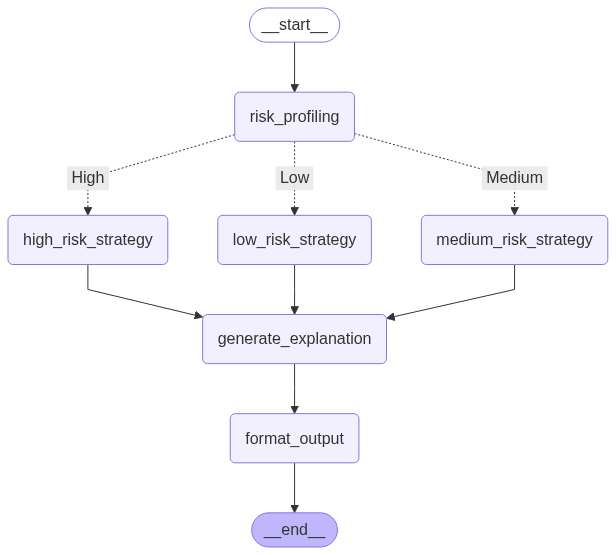

In [96]:
from IPython.display import display,Image
mermaid_diagram = app.get_graph().draw_mermaid_png()
display(Image(mermaid_diagram))